In [1]:
from Chao_Xu_Module import check_duplicate

In [2]:
# load packages
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.filterwarnings("ignore")
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import calibration
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# <center>  Boston Crime Data Analysis and Modeling </center>

<center> ALY 6140 </center>
<center> To: Dr. Kamen Madjarov </center>
<center> Chao Xu </center>

# Contents


- [Part 1: Introduction](#Part-1:-Introduction)
- [Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
- [Part 3: Modeling and Time Series Analysis](#Part-3:-Modeling-and-Time-Series-Analysis)
- [Part 4: Conclsuion](#Part-4:-Conclusion)


# Part 1: Introduction 

## Part 1.1: Summary 

  In this project, the [dataset](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b) is publicly available from Boston Police Department. *Why I selected this dataset?* the biggest reason is that I live in Boston and want to know how safe it is. In this project, it contains four parts, the first section is introduction and data extraction; The second part is about data cleaning and feature preprocessing; in the third section, it contains two different analysis models, which are K-means for spatial analysis and SARIMAX for time series analysis; the last part is conclusion.

## Part 1.2: Dataset Description

This dataset is provided by Boston Police Department(BPD), which document the initial details surrounding an incident to which BPD officers respond. In this dataset, there are 10 main features:
- incident_num: Internal BPD report number
- offense_code: Numerical code of offense description
- offense_Description: Primary descriptor of incident
- district: what district the crime was reported in 
- reporting_area: RA number associated with the where the crime was reported from.
- shooting: Indicated a shooting took place.
- occurred_on: Earliest date and time the incident could have taken place
- UCR_Part: Universal Crime Reporting Part number (1,2,3)
- street: Street name the incident took place

The dataset begins from August 2015 to today, As of October 17th, 2019, there are 426820 incidents and 17 variables.

## Part 1.3: Loading Data

In [3]:
# Loading the data from website
data_url = 'https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmppahwuiqg.csv'
my_data = pd.read_csv(data_url)
my_data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192078648,3114,Investigate Property,INVESTIGATE PROPERTY,B3,427,NaN,2019-09-29 06:39:00,2019,9,Sunday,6,Part Three,WILMORE ST,42.278,-71.092,"(42.27796370, -71.09246318)"
1,I192078647,3115,Investigate Person,INVESTIGATE PERSON,A1,,NaN,2019-09-29 03:45:00,2019,9,Sunday,3,Part Three,NASHUA ST,42.368,-71.066,"(42.36769032, -71.06586347)"
2,I192078645,3301,Verbal Disputes,VERBAL DISPUTE,B3,450,NaN,2019-09-29 06:00:00,2019,9,Sunday,6,Part Three,ASPINWALL RD,42.292,-71.072,"(42.29181580, -71.07244098)"
3,I192078642,3820,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,D4,269,NaN,2019-09-29 05:50:00,2019,9,Sunday,5,Part Three,ALBANY ST,42.332,-71.075,"(42.33241896, -71.07501315)"
4,I192078640,3115,Investigate Person,INVESTIGATE PERSON,A7,28,NaN,2019-09-29 01:30:00,2019,9,Sunday,1,Part Three,PARIS ST,42.373,-71.036,"(42.37339168, -71.03647779)"


In [4]:
print('Number of rows: ' + str(my_data.shape[0])) # row count
print('Number of columns: ' + str(my_data.shape[1])) # col count

Number of rows: 426820
Number of columns: 17


# Part 2: Feature Preprocessing

## Part 2.1: Exclude duplicated data

In [5]:
# check the duplicated data:
check_duplicate(my_data)

'The number of duplicated data is: 751'

In [6]:
# Remove all duplicated data
my_data = my_data.drop_duplicates()
print('All duplicated data have been dropped')
print('The total number of rows: %d' % my_data.shape[0])

All duplicated data have been dropped
The total number of rows: 426069


## Part 2.2: Convert features

From the dataset, we can see that the **district** is provided by code, so if I want to more specific information, I need to convert those two columns into names.

In [7]:
# convert district into names
map_district = {
    'A1' : 'Downtown',
    'A15' : 'Charlestown',
    'A7' : 'East Boston',
    'B2' : 'Roxbury',
    'B3' : 'Mattapan',
    'C6' : 'South Boston',
    'C11' : 'Dorchester',
    'D4' : 'South End',
    'D14' : 'Brighton',
    'E5' : 'West Roxbury',
    'E13' : 'Jamaica Plain',
    'E18' : 'Hyde Park'}

my_data['DISTRICT'] = my_data['DISTRICT'].map(map_district)

## Part 2.3: Missing value

Check missing value. From the result, I found most missing value are from shooting, street, lat and long. For the shooting, the missing value make sense, because if there is no shooting, the value will be null. For street, lat and long, it maybe caused by the location is unknown, which need me to figure it out. 

#### Missing Value ####
DISTRICT      2170
SHOOTING    424689
UCR_PART       106
STREET       12378
Lat          27172
Long         27172
dtype: int64


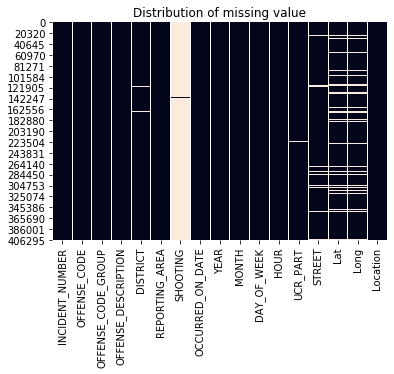

In [8]:
# find the columns with missing value
print('#### Missing Value ####')
print(my_data.isnull().sum()[my_data.isna().sum() != 0])

# plot the missing value distribution
sns.heatmap(my_data.isnull(), cbar=False)
plt.title('Distribution of missing value')
plt.show()

### Part 2.3.1: Handle with missing value

#### District, Street, lat, long
Handle those features together, because as we know, those features are about locations. Therefore, if those all are null, I should drop them all. if I don't know district and street, but I know the latitude and longtitude, we can fill the missing value with latitude and longtitude. By looking the lat and long, I found there are so many records filled by -1, all of those records should be considered as missing value.

In [9]:
# fill all -1 with nan
my_data.Lat.replace(-1, np.nan, inplace=True)
my_data.Long.replace(-1, np.nan, inplace=True)

In [10]:
# Find all records that four features with missing value
all_na = my_data[(my_data.DISTRICT.isnull() & my_data.STREET.isnull() & my_data.Lat.isnull())]
my_data = my_data.drop(all_na.index)

In [11]:
print(my_data.isnull().sum()[my_data.isna().sum() != 0])

DISTRICT      1942
SHOOTING    424461
UCR_PART       106
STREET       12150
Lat          27870
Long         27870
dtype: int64


By now, we just have 1942 missing value in district. One of the ideal method to fix those is use Latitude and Longitude if avaiable, but if all Latitude and Longtitude are missing, we should drop those records.

In [12]:
my_data = my_data.dropna(subset=['Lat', 'Long'])
print(my_data.isnull().sum()[my_data.isna().sum() != 0])

DISTRICT      1110
SHOOTING    396644
UCR_PART       105
STREET        2386
dtype: int64


Now, we can use the latitude and longtitude to fill the missing value of district and street. But when I check the report, there is no specific latitude and longtitude range. So I want to use the classification model to predict the missing district based on Lat and Long. 

In [13]:
district = my_data[my_data.DISTRICT.notnull()]
district_na = my_data[my_data.DISTRICT.isnull()]
X_train = district[['Lat', 'Long']]
y_train = district['DISTRICT']
X_test = district_na[['Lat', 'Long']]

In [14]:
# Random Forest
classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train, y_train)
classifier_RF.predict(X_test)

array(['Roxbury', 'South Boston', 'Jamaica Plain', ..., 'East Boston',
       'West Roxbury', 'Jamaica Plain'], dtype=object)

In [15]:
fill1 = pd.Series(classifier_RF.predict(X_test), my_data[my_data['DISTRICT'].isnull()].index)
my_data['DISTRICT'].fillna(fill1, inplace=True)

Similiarly, fill the Street missing value based on Lat and Long.

In [16]:
street = my_data[my_data.STREET.notnull()]
street_na = my_data[my_data.STREET.isnull()]
X_train = street[['Lat', 'Long']]
y_train = street['STREET']
X_test = street_na[['Lat', 'Long']]

# Random Forest
classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train, y_train)
classifier_RF.predict(X_test)

fill2 = pd.Series(classifier_RF.predict(X_test), my_data[my_data['STREET'].isnull()].index)
my_data['STREET'].fillna(fill2, inplace=True)

In [17]:
print(my_data.isnull().sum()[my_data.isna().sum() != 0])

SHOOTING    396644
UCR_PART       105
dtype: int64


Now, there is no missing value in DISTRICT, STREET, Lat and Long.

#### UCR_PART
By looking at the value of UCR_PART, we found there are 1525 observations coded as other. Under such condition, we can impute them into other group

In [18]:
my_data.UCR_PART.value_counts()

Part Three    198186
Part Two      121276
Part One       76879
Other           1525
Name: UCR_PART, dtype: int64

In [19]:
my_data['UCR_PART'] = my_data['UCR_PART'].fillna('Other')

#### SHOOTING
Because missing value in shooting means shoot involved, so we can convert them into 'No shoot'.

In [20]:
my_data['SHOOTING'] = my_data['SHOOTING'].fillna('No shoot')

## Part 2.4: Exploratory data analysis

### Part 2.3.4: Understand the features

#### Crime category
Find the top 10 crimes in Boston. from the result, we can see that the top 3 crime are Motor Vehicle accident response, Larceny and Medical assistance.

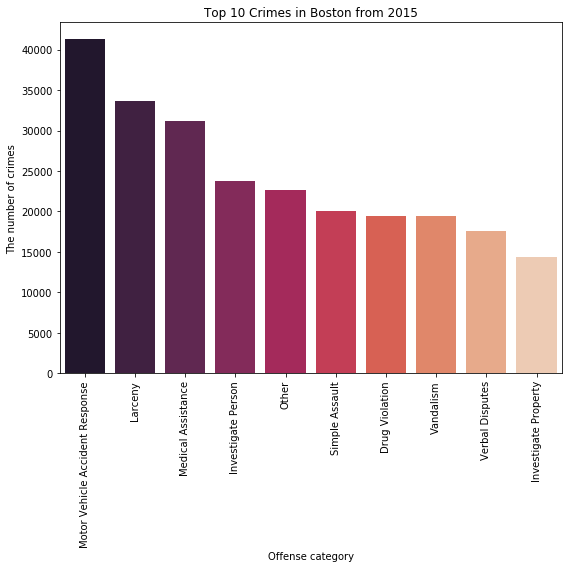

In [21]:
# crime category distribution
crime_category = pd.DataFrame(my_data.OFFENSE_CODE_GROUP.value_counts())[:10]
plt.figure(figsize=(8, 8))
sns.barplot(x=crime_category.index, y='OFFENSE_CODE_GROUP', data=crime_category, palette="rocket")
plt.title('Top 10 Crimes in Boston from 2015')
plt.xticks(rotation=90)
plt.xlabel('Offense category')
plt.ylabel('The number of crimes')
plt.tight_layout()
plt.show()

#### Crime District
Find the crime distribution of district in Boston. From the result, we can see that the top 3 district are Roxbury, Dorchester and South End.

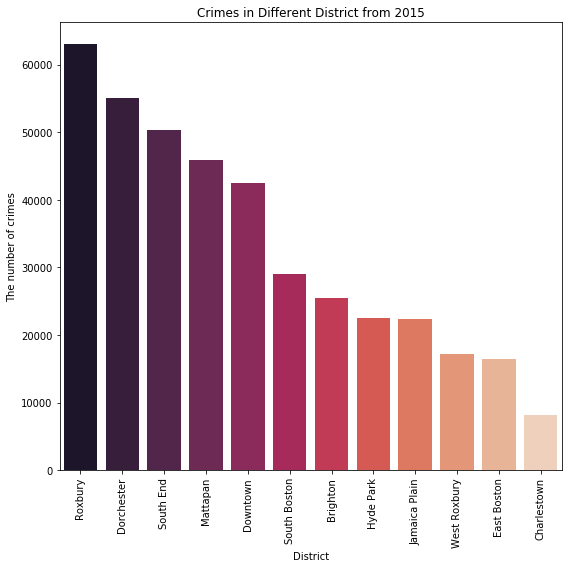

In [22]:
crime_district = pd.DataFrame(my_data.DISTRICT.value_counts())
plt.figure(figsize=(8, 8))
sns.barplot(x=crime_district.index, y='DISTRICT', data=crime_district, palette="rocket")
plt.title('Crimes in Different District from 2015')
plt.xticks(rotation=90)
plt.xlabel('District')
plt.ylabel('The number of crimes')
plt.tight_layout()
plt.show()

#### Date

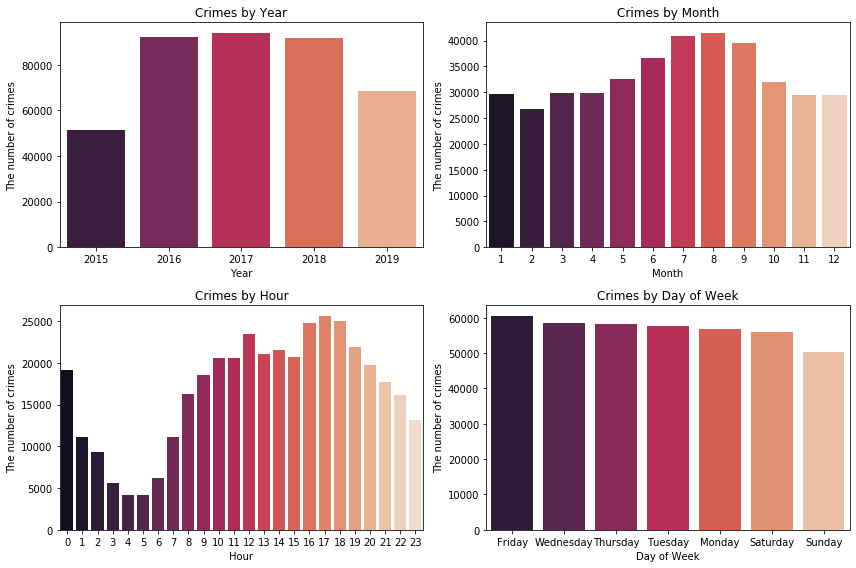

In [23]:
# crimes by year, month, day of week, hour
fig, axes = plt.subplots(2,2,figsize=(12, 8))

# Year
crime_year = pd.DataFrame(my_data.YEAR.value_counts())
sns.barplot(x=crime_year.index, y='YEAR', data=crime_year, palette="rocket", ax=axes[0,0])
axes[0, 0].set_title('Crimes by Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('The number of crimes')


# Month
crime_month = pd.DataFrame(my_data.MONTH.value_counts())
sns.barplot(x=crime_month.index, y='MONTH', data=crime_month, palette="rocket", ax=axes[0,1])
axes[0, 1].set_title('Crimes by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('The number of crimes')

# Hour
crime_hour = pd.DataFrame(my_data.HOUR.value_counts())
sns.barplot(x=crime_hour.index, y='HOUR', data=crime_hour, palette="rocket", ax=axes[1,0])
axes[1, 0].set_title('Crimes by Hour')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('The number of crimes')

# Day of Week
crime_day = pd.DataFrame(my_data.DAY_OF_WEEK.value_counts())
sns.barplot(x=crime_day.index, y='DAY_OF_WEEK', data=crime_day, palette="rocket", ax=axes[1,1])
axes[1, 1].set_title('Crimes by Day of Week')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('The number of crimes')


plt.tight_layout()
plt.show()


From the result above, we can see that the number of crimes in 2017 is most than other years. In addition, July, August, Sepetember have relatively more crimes than other months. About hours, we can see that 16, 17, 18 are higher than other times. Finally, Friday has most crimes than other days.

### Shooting

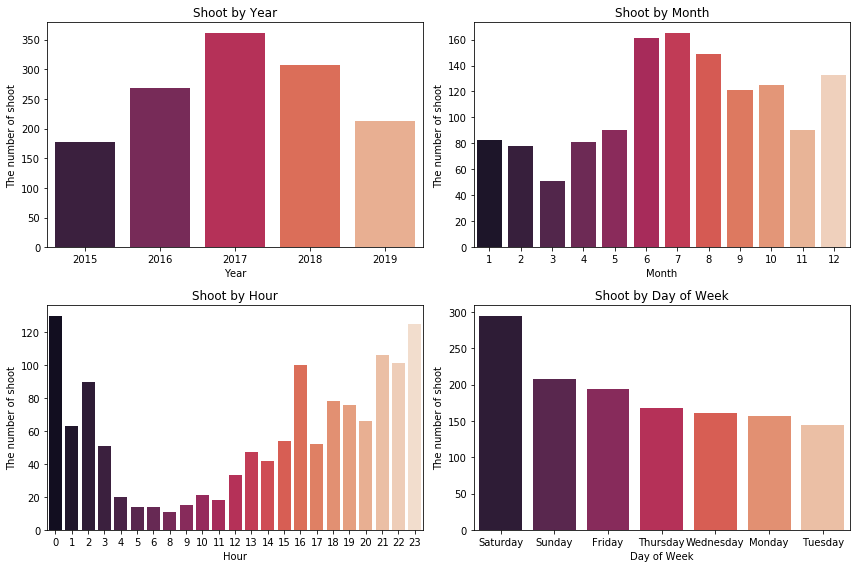

In [24]:
shoot = my_data.loc[my_data['SHOOTING']=='Y']

# shooting by year, month, day of week, hour
fig, axes = plt.subplots(2,2,figsize=(12, 8))

# Year
shoot_year = pd.DataFrame(shoot.YEAR.value_counts())
sns.barplot(x=shoot_year.index, y='YEAR', data=shoot_year, palette="rocket", ax=axes[0,0])
axes[0, 0].set_title('Shoot by Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('The number of shoot')


# Month
shoot_month = pd.DataFrame(shoot.MONTH.value_counts())
sns.barplot(x=shoot_month.index, y='MONTH', data=shoot_month, palette="rocket", ax=axes[0,1])
axes[0, 1].set_title('Shoot by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('The number of shoot')

# Hour
shoot_hour = pd.DataFrame(shoot.HOUR.value_counts())
sns.barplot(x=shoot_hour.index, y='HOUR', data=shoot_hour, palette="rocket", ax=axes[1,0])
axes[1, 0].set_title('Shoot by Hour')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('The number of shoot')

# Day of Week
shoot_day = pd.DataFrame(shoot.DAY_OF_WEEK.value_counts())
sns.barplot(x=shoot_day.index, y='DAY_OF_WEEK', data=shoot_day, palette="rocket", ax=axes[1,1])
axes[1, 1].set_title('Shoot by Day of Week')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('The number of shoot')


plt.tight_layout()
plt.show()

From the result above, we can see that the number of shoot in 2017 is most than other years. In addition, June, July, August have relatively more crimes than other months. About hours, we can see that 23, 24 are higher than other times. Finally, Saturday has most crimes than other days.

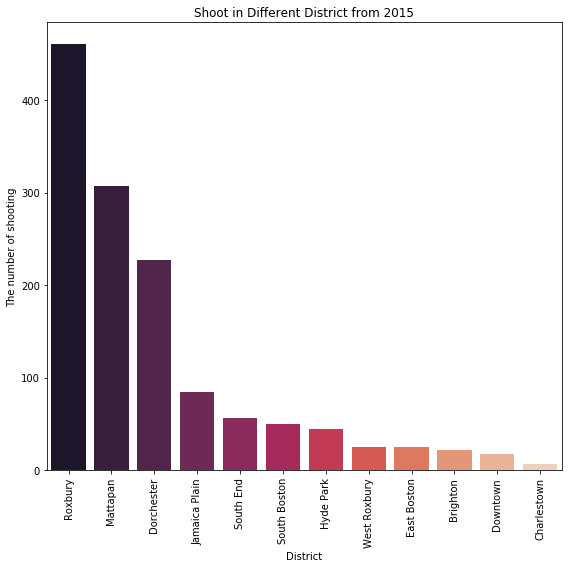

In [25]:
# Shooting by district
shoot_district = pd.DataFrame(shoot.DISTRICT.value_counts())
plt.figure(figsize=(8, 8))
sns.barplot(x=shoot_district.index, y='DISTRICT', data=shoot_district, palette="rocket")
plt.title('Shoot in Different District from 2015')
plt.xticks(rotation=90)
plt.xlabel('District')
plt.ylabel('The number of shooting')
plt.tight_layout()
plt.show()

From the result above, we can see that the number of shoot in Roxbury is most than other district.

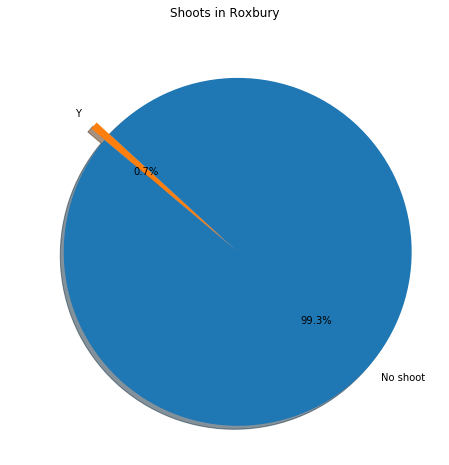

In [46]:
# Find the shooting percentage in Roxbury
roxbury = my_data.loc[my_data['DISTRICT']=='Roxbury']
shoot_rox = pd.DataFrame(roxbury.SHOOTING.value_counts())
plt.figure(figsize=(8, 8))
plt.pie(shoot_rox, explode=(0.1, 0), labels=shoot_rox.index, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Shoots in Roxbury')
plt.show()


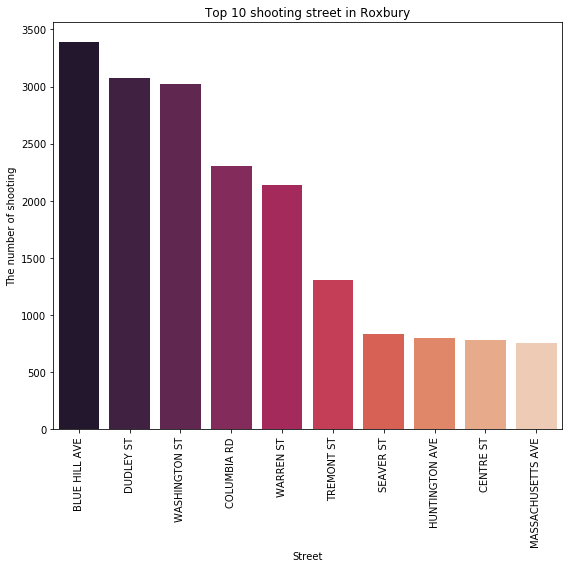

In [27]:
# analyze the shoot in Roxbury
shooting_rox = roxbury.loc[roxbury['SHOOTING']=='Y']
street = pd.DataFrame(roxbury.STREET.value_counts())
street = street[:10]
plt.figure(figsize=(8, 8))
sns.barplot(x=street.index, y='STREET', data=street, palette="rocket")
plt.title('Top 10 shooting street in Roxbury')
plt.xticks(rotation=90)
plt.xlabel('Street')
plt.ylabel('The number of shooting')
plt.tight_layout()
plt.show()

From the result above, we can see the Blue hill ave is the most dangerous street in Roxbury, which occur over 3000 incidents of shooting from 2015.

#### Downtown safety analysis

Text(0, 0.5, 'The number of Crimes')

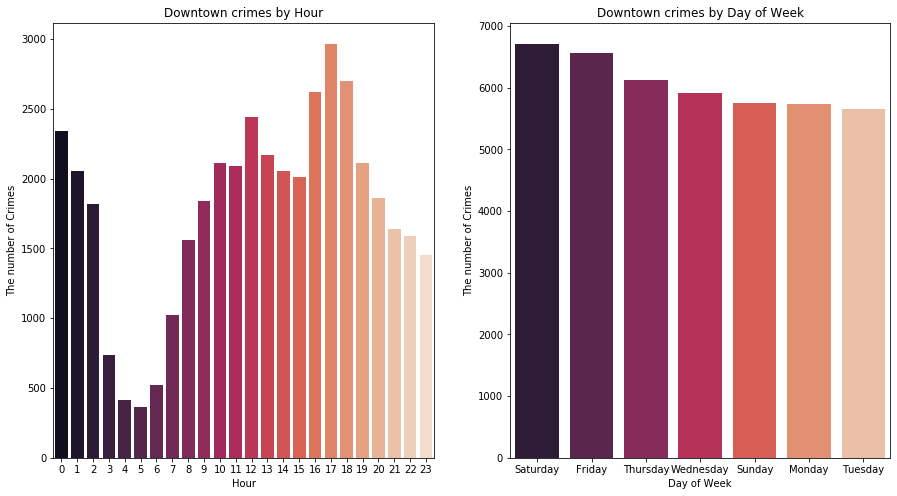

In [28]:
# downtown crimes by hour
downtown = my_data.loc[my_data['DISTRICT']=='Downtown']

# crimes in downtown by day of week, hour
fig, axes = plt.subplots(1,2,figsize=(15, 8))

# Hour
downtown_hour = pd.DataFrame(downtown.HOUR.value_counts())
sns.barplot(x=downtown_hour.index, y='HOUR', data=downtown_hour, palette="rocket", ax=axes[0])
axes[0].set_title('Downtown crimes by Hour')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('The number of Crimes')

# Day of Week
downtown_day = pd.DataFrame(downtown.DAY_OF_WEEK.value_counts())
sns.barplot(x=downtown_day.index, y='DAY_OF_WEEK', data=downtown_day, palette="rocket", ax=axes[1])
axes[1].set_title('Downtown crimes by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('The number of Crimes')


From the result, the crime trend has highly correlation with the trends of human traffic. 16, 17, 18 and Saturday have most people in downtown for entertainment or shopping.

# Part 3: Modeling and Time Series Analysis

## Part 3.1: K-means -- Spatial distribution

### Part 3.1.1: Find the best k

In [29]:
features = my_data[['Lat', 'Long']]

# select best k
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features)
    sum_of_squared_distances.append(km.inertia_)

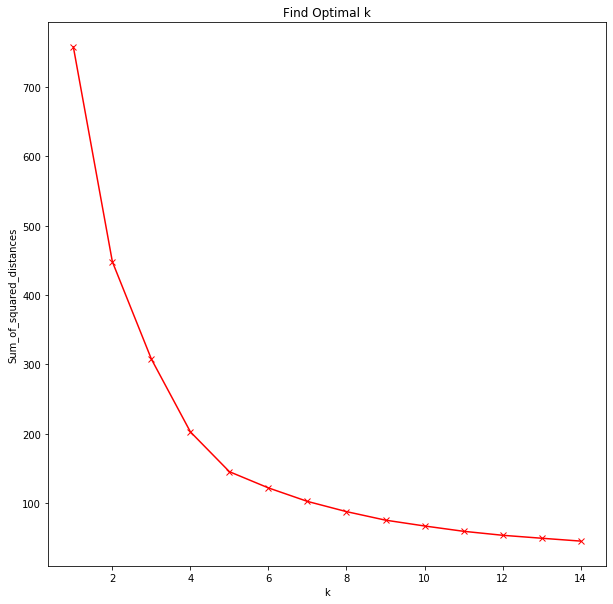

In [30]:
# elbow method
plt.figure(figsize=(10, 10))
plt.plot(K, sum_of_squared_distances, 'rx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Find Optimal k')
plt.show()

As k increases, the sum of squared distance tends to zero. 
Above is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the optimal k must be in elbow on the arm. So the best k is 5.

In [31]:
# Train the model
location = my_data['Location']
kmeans = KMeans(n_clusters=5, random_state=6140).fit(features)

# find center
center = pd.DataFrame(kmeans.cluster_centers_)
predict = kmeans.predict(features)

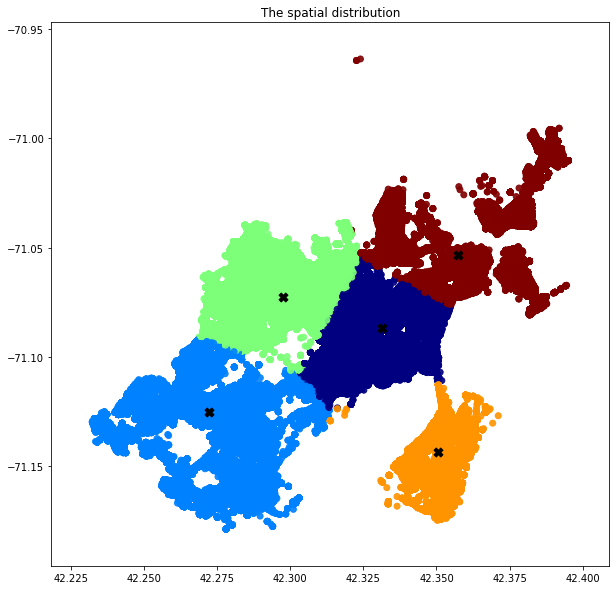

In [32]:
# Spatial distribution
plt.figure(figsize=(10, 10))
plt.scatter(features['Lat'], features['Long'], c=(predict),cmap=plt.cm.jet, alpha=0.9)
plt.scatter(center[0], center[1], s=80, color='black', marker='X')
plt.title("The spatial distribution")
plt.show()

Based on the above plot, we can conclude that if the police station locate in the center of each cluster, the working efficiency is highest.

## Part 3.2: Time Series Analysis - SARIMAX

In [33]:
# extract the date
my_data['Date'] = my_data.OCCURRED_ON_DATE.map(lambda x: x.split(' ')[0])

In [34]:
# convert date into time series
time_span = pd.date_range(my_data.Date.min(), my_data.Date.max())
date = pd.to_datetime(my_data.Date.value_counts().index)
index = sorted(date)
data = my_data.Date.value_counts().values[np.argsort(date)]
ts = pd.DataFrame(data = data, index = index, columns = ['count'])
ts = ts.reindex(time_span, fill_value=0)

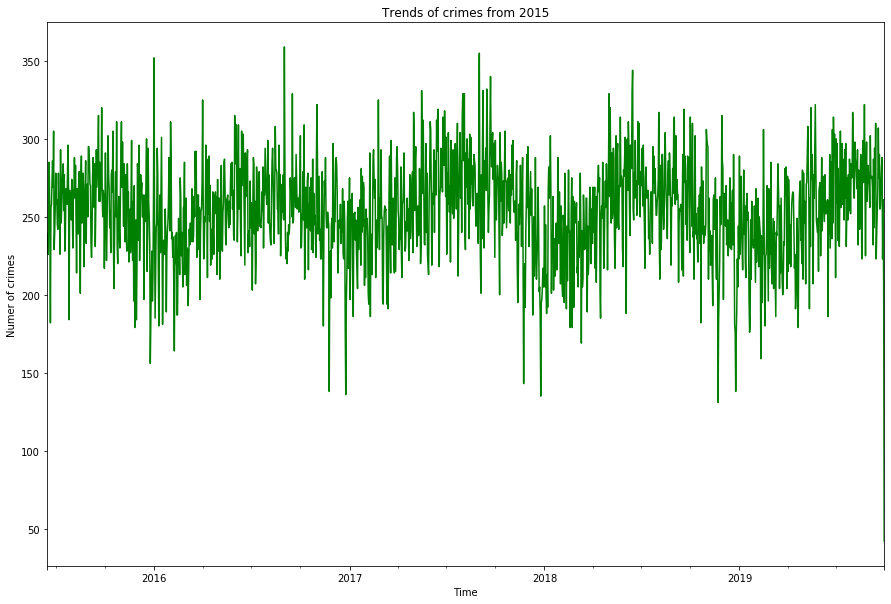

In [35]:
df_ts = ts
#plot the time series
plt.figure(figsize=(15, 10))
df_ts['count'].plot(color='g')
plt.title('Trends of crimes from 2015')
plt.xlabel('Time')
plt.ylabel('Numer of crimes')
plt.show()

From the plot above, we can see the crime fluctuate about 250 incidents of crime, it is quite obvious that the trend is directly related to the seasons, so I need to decompose the time series.

### Part 3.2.1: Decomposition

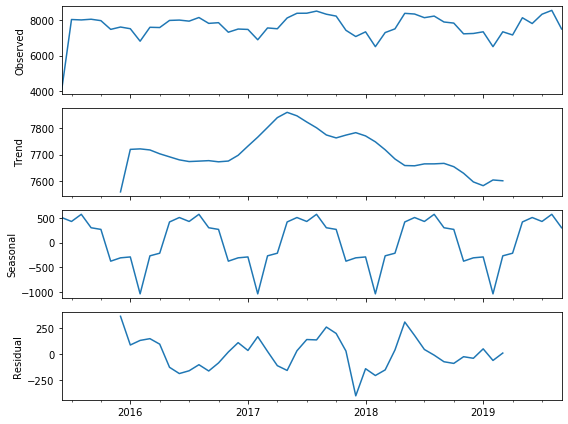

In [36]:
# decompose the time series

y = df_ts.resample('MS').sum() # sum by month
plt.rcParams['figure.figsize'] = 8, 6
decomposition = seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

From the plots above, we can see that the trend increase at the beginning and go up to the top at mid of 2017, and then decrease with time, that maybe caused by the appropriate method to avoid the crimes.

In [37]:
y.head()

,count
2015-06-01,4062
2015-07-01,8038
2015-08-01,8014
2015-09-01,8054
2015-10-01,7974


### Part 3.2.2: Tuning the parameter

In [38]:
# hold last 12 months to test
y_past, y_future = y[:-12], y[-12:]

In [39]:
# tuning the parameter
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [40]:
aic_min = float("inf")
param = (0,0,0,0,0,0)
best_model = None

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(y_past,
                          order = x1,
                          seasonal_order = x2,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = mod.fit()
            if results.aic < aic_min:
                aic_min = results.aic
                param = x1 + x2
                best_model = mod
        except:
            continue

In [41]:
print("Best (p,d,q,P,D,Q,S) =", param)

Best (p,d,q,P,D,Q,S) = (1, 1, 0, 1, 1, 0, 12)


In [42]:
results = best_model.fit()

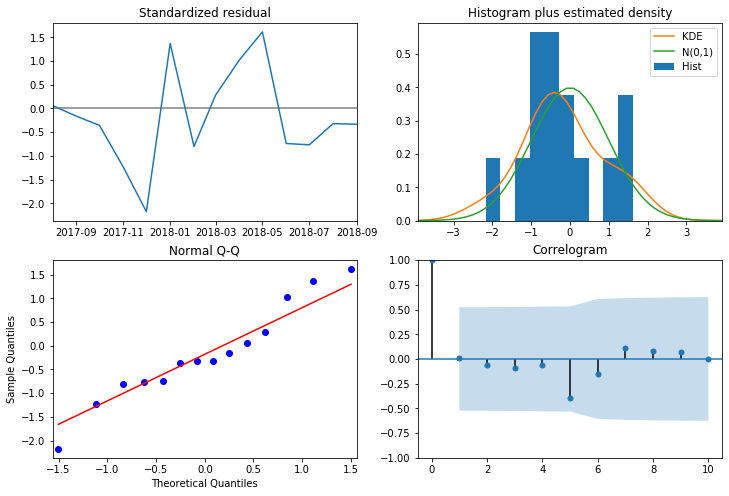

In [43]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

From the result above, the model diagnosis mainly checks whether the model is abnormal. 
- The residual of the first graph is relatively stable, 
- the data of the second graph obeys the positive distribution, 
- the third graph fits better, 
- the fourth graph also tends to zero. 
In conclusion, the model is in good condition and can be used for forecasting.

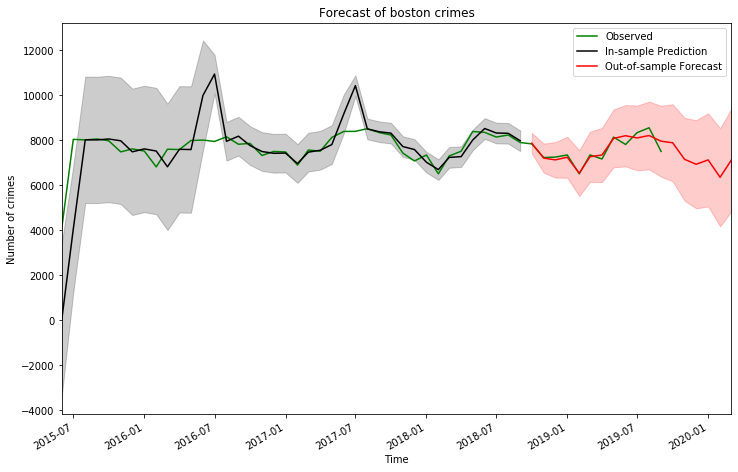

In [44]:
pred = results.get_prediction(start = y_past['2015-06':].index[0],  dynamic=False)
pred_ci = pred.conf_int() # 95% confidence interval 

forecast = results.get_forecast(steps=18) # forecast for the next 18 months
forecast_ci = forecast.conf_int() # 95% confidence interval 

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(y['2015-06':].index, y['2015-06':], label='Observed', color='g')

pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-sample Forecast', color='r')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_title('Forecast of boston crimes')
ax.set_xlabel('Time')
ax.set_ylabel('Number of crimes')
plt.legend()
plt.show()

In [45]:
forecast.predicted_mean[-6:]

2019-10-01   7886.198
2019-11-01   7149.352
2019-12-01   6930.666
2020-01-01   7124.017
2020-02-01   6350.178
2020-03-01   7114.223
Freq: MS, dtype: float64

Frome the result above, we can see that the model in sample predict has relatively higher accuracy of prediction; for the out sample forecast, the forecast has pretty high accuracy, and we can also know the number of crimes in the next 6 months.

# Part 4: Conclusion

From the analysis part above, there are several insights we can conclude:
- the top 3 crime category are Motor Vehicle accident response, Larceny and Medical assistance.
- the top 3 district with most crimes are Roxbury, Dorchester and South End.
- the number of crimes in 2017 is highest. In addition, July, August, Sepetember have relatively more crimes than other months. About hours, we can see that 16, 17, 18 are higher than other times. Finally, Friday has most crimes than other days.
- the number of shoot in 2017 is most than other years. In addition, June, July, August have relatively more crimes than other months. About hours, we can see that 23, 24 are higher than other times. Finally, Saturday has most crimes than other days.
- the number of shoot in Roxbury is highest than other district.
- the crime trend has highly correlation with the trends of human traffic. 16, 17, 18 and Saturday have most people in downtown for entertainment or shopping.
- Based on the K-means result, we can conclude that if the police station locate in the center of each cluster, the working efficiency is highest, in addition, the police can rearrange the police force based the k-means result.
- Based on the SARIMA model forecast and under 95% confidence interval, we can know that the number of crimes in October is 7886, 7149 in November, 6931 in December, 7124 in Junaury 2020, 6350 in Febrary 2020, 7114 in March 2020.

### Suggestions:
Based on above insights, I can offer several suggestion for Boston police department and visitors who plan to have a tour in Boston:
- For Boston police department: 
    - based on result of k-means, it can help BPD to rearrange the police forces. To be exact, assign police forces to the center of each cluster, which can save time to response the crime incidents and improve the working efficiency.
    - according the SARIMAX models forecast, the total number of crimes in next month, November, will be 7149.
- For students or visitors:
    - based on the EDA, if you want to have a tour in Boston, you should avoid the July, August and Septmber.
    - for students in Boston, after 22 pm, it is not a safe time to walk out.
    - at the weekends, students and vistors should go shopping in the morning or noon, which are safer than afternoon and night.
    - try not going to Roxbury alone, because this district is not much safer than others.
    - if you living at Roxbury, try not going to Blue Hill Ave, Dudley ST and Washington ST, because those streets occur total over 10,000 incidents of shooting from 2015.
